In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports
# Please refer to requirements.txt for a full list of all libraries and their versions used in this project.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,SeparableConv2D,MaxPooling2D,BatchNormalization,SpatialDropout2D,Dropout,Activation,Dense,Lambda,Input,Flatten
from tensorflow.keras.regularizers import l2

import tensorflow as tf

# Setting random seeds to reduce the amount of randomness in the neural net weights and results.
# The results may still not be exactly reproducible.
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Testing to ensure GPU is being utilized.

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Unzipping the dataset file combined_faces.zip

combined_faces_zip_path = "/content/drive/My Drive/539/combined_faces.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces.zip')


# Unzipping the dataset file combined_faces.zip

combined_faces_zip_path = "/content/drive/My Drive/539/combined_faces_train_augmented.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces_train_augmented.zip')

Done unzipping combined_faces.zip
Done unzipping combined_faces_train_augmented.zip


In [ ]:
# Importing the augmented training dataset and testing dataset to create tensors of images using the filename paths.

train_aug_df = pd.read_csv("/content/drive/My Drive/539/images_filenames_labels_train_augmented.csv")
test_df = pd.read_csv("/content/drive/My Drive/539/images_filenames_labels_test.csv")

# Dropping the age column since classes of age-ranges have been re-distributed from 11 to 7 classes.

train_aug_df.drop(columns=['target'], inplace=True)

# Dropping the age column since classes of age-ranges have been re-distributed from 11 to 7 classes.

test_df.drop(columns=['target'], inplace=True)

In [ ]:
# Defining a function to return the class labels corresponding to the re-distributed 7 age-ranges.

def class_labels_reassign(age):

    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

train_aug_df['target'] = train_aug_df['age'].map(class_labels_reassign)
test_df['target'] = test_df['age'].map(class_labels_reassign)

In [ ]:
train_aug_df['target'].value_counts(normalize=True)

4    0.279382
3    0.199821
5    0.167186
0    0.095303
2    0.093682
1    0.084083
6    0.080543
Name: target, dtype: float64

In [ ]:
test_df['target'].value_counts(normalize=True)

4    0.279415
3    0.199781
5    0.167131
0    0.095361
2    0.093669
1    0.084113
6    0.080530
Name: target, dtype: float64

In [ ]:
# Converting the filenames and target class labels into lists for augmented train and test datasets.

train_aug_filenames_list = list(train_aug_df['filename'])
train_aug_labels_list = list(train_aug_df['target'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target'])

# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_aug_filenames_tensor = tf.constant(train_aug_filenames_list)
train_aug_labels_tensor = tf.constant(train_aug_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    image_resized = tf.image.resize(image_decoded, [98, 98])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_aug_dataset = train_aug_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
# Defining the architecture of the sequential neural network.

final_cnn = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(98, 98, 1)))    # 3rd dim = 1 for grayscale images.
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
final_cnn.add(GlobalAveragePooling2D())

# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
final_cnn.add(Dense(132, activation='relu'))

# Output layer with 7 nodes (equal to the no. of classes).
final_cnn.add(Dense(7, activation='softmax'))

final_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        320       
                                                                 
 average_pooling2d (AverageP  (None, 48, 48, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 23, 23, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 average_pooling2d_2 (Averag  (None, 10, 10, 128)      0

In [ ]:
# A callback is a set of functions to be applied at given stages of the training procedure.

import math
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler

#  When training a neural network, the learning rate is often the most important 
# hyperparameter to tune. When training deep neural networks, it is often useful 
# to reduce learning rate as the training progresses.

# LRS in Keras reduces the learning rate by a certain factor after certain no of epochs

def step_decay(epoch):
	initial_lrate = 0.008
	drop = 0.5
	epochs_drop = 5.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Adam(lr=0.0)                                     # 0.0 here signifies this is not to be used
lrate = LearningRateScheduler(step_decay)


# final_cnn.compile(optimizer=opt, 
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# callbacks_list = [lrate]

# # It is this callback that allows a function to invoke during program execution.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Compiling the above created CNN architecture.

final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Creating a TensorBoard callback object and saving it at the desired location.

tensorboard = TensorBoard(log_dir=f"/content/drive/My Drive/539/cnn_logs/final_cnn")

# Creating a ModelCheckpoint callback object to save the model according to the value of val_accuracy.

checkpoint = ModelCheckpoint(filepath=f"/content/drive/My Drive/539/final_cnn_model_checkpoint.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

In [ ]:
# Fitting the above created CNN model.

final_cnn_history = final_cnn.fit(train_aug_dataset,
                                  batch_size=512,
                                  validation_data=test_dataset,
                                  epochs=60,
                                  callbacks=[tensorboard, checkpoint],
                                  shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                                 )

Epoch 1/60
458/458 [==============================] - ETA: 0s - loss: 1.8269 - accuracy: 0.2956
Epoch 1: val_accuracy improved from -inf to 0.34223, saving model to /content/drive/My Drive/539/final_cnn_model_checkpoint.h5
458/458 [==============================] - 321s 671ms/step - loss: 1.8269 - accuracy: 0.2956 - val_loss: 1.6581 - val_accuracy: 0.3422
Epoch 2/60
458/458 [==============================] - ETA: 0s - loss: 1.5732 - accuracy: 0.3677
Epoch 2: val_accuracy improved from 0.34223 to 0.41400, saving model to /content/drive/My Drive/539/final_cnn_model_checkpoint.h5
458/458 [==============================] - 262s 571ms/step - loss: 1.5732 - accuracy: 0.3677 - val_loss: 1.4284 - val_accuracy: 0.4140
Epoch 3/60
458/458 [==============================] - ETA: 0s - loss: 1.4037 - accuracy: 0.4266
Epoch 3: val_accuracy improved from 0.41400 to 0.43619, saving model to /content/drive/My Drive/539/final_cnn_model_checkpoint.h5
458/458 [==============================] - 263s 574ms/s

In [ ]:
final_cnn.save("/content/drive/My Drive/539/new_combaug_age7_adam_mod.h5")

In [ ]:
import plotly.graph_objects as go
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=final_cnn_history.history['accuracy'],
                    name='Train'))
fig.add_trace(go.Scattergl(
                    y=final_cnn_history.history['val_accuracy'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for age feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 432x288 with 0 Axes>

# Evaluation

In [ ]:
# predict one image
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import load_model
final_cnn = load_model('/content/drive/My Drive/539/comb_aug_age7_adam_mod.h5')
final_cnn_score = final_cnn.evaluate(test_dataset, verbose=1)

20/20 [==============================] - 18s 400ms/step - loss: 1.4653 - accuracy: 0.7034


In [ ]:
# Printing the relevant score summary.

final_cnn_labels = final_cnn.metrics_names
print(f'CNN model {final_cnn_labels[0]} \t\t= {round(final_cnn_score[0], 3)}')
print(f'CNN model {final_cnn_labels[1]} \t= {round(final_cnn_score[1], 3)}')

CNN model loss 		= 1.465
CNN model accuracy 	= 0.703


In [ ]:
# Generating predictions from the model above.

final_cnn_pred = final_cnn.predict(test_dataset)
final_cnn_pred = final_cnn_pred.argmax(axis=-1)

In [ ]:
# Generating a confusion matrix based on above predictions.

conf_mat = confusion_matrix(test_labels_list, final_cnn_pred)
conf_mat

array([[ 899,   44,    2,    3,    8,    0,    2],
       [  62,  719,   36,    9,   17,    2,    0],
       [   1,   61,  632,  171,   75,    1,    0],
       [   2,   16,  102, 1166,  700,   19,    2],
       [   1,   16,   52,  551, 2031,  148,    8],
       [   0,   12,   10,   45,  506, 1028,   78],
       [   0,    2,    4,    5,   35,  172,  591]])

In [ ]:
# Defining a function to plot the confusion matrix in a grid for easier visualization.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'/content/drive/My Drive/539/{export_as}.png', bbox_inches='tight');

Normalized confusion matrix


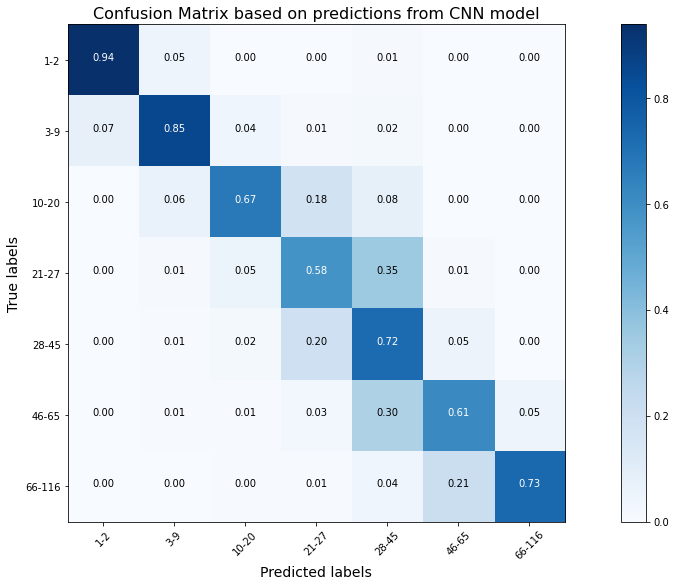

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )

plt.show()

Confusion matrix, without normalization


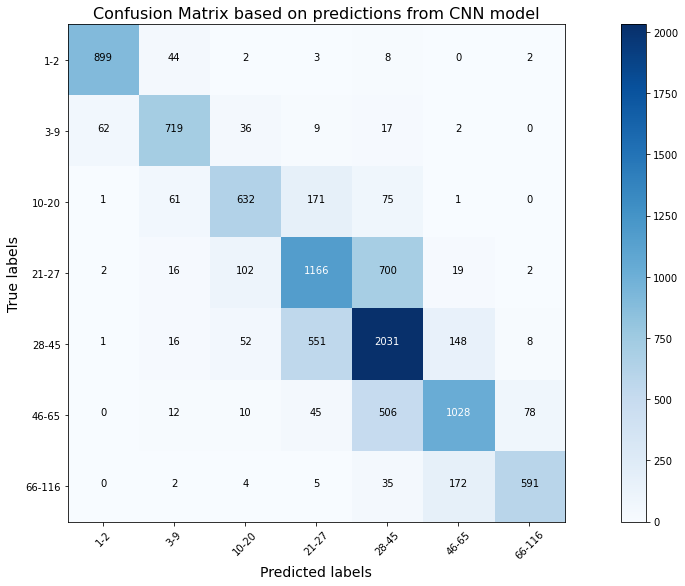

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat"
                     )

plt.show()